<a href="https://colab.research.google.com/github/danielsoy/ALOCC-CVPR2018/blob/master/Alibi_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Method:
The Variational Auto-Encoder (VAE) outlier detector is first trained on a batch of unlabeled, but normal (inlier) data. Unsupervised training is desireable since labeled data is often scarce. The VAE detector tries to reconstruct the input it receives. If the input data cannot be reconstructed well, the reconstruction error is high and the data can be flagged as an outlier. The reconstruction error is either measured as the mean squared error (MSE) between the input and the reconstructed instance or as the probability that both the input and the reconstructed instance are generated by the same process.

Dataset
CIFAR10 consists of 60,000 32 by 32 RGB images equally distributed over 10 classes.

In [1]:
# https://docs.seldon.io/projects/alibi-detect/en/latest/examples/od_vae_cifar10.html

In [2]:
!pip install alibi_detect

     |████████████████████████████████| 300 kB 4.4 MB/s 
     |████████████████████████████████| 4.8 MB 44.0 MB/s 
     |████████████████████████████████| 458.3 MB 12 kB/s 
     |████████████████████████████████| 3.4 MB 55.2 MB/s 
     |████████████████████████████████| 1.3 MB 45.0 MB/s 
     |████████████████████████████████| 5.6 MB 47.4 MB/s 
     |████████████████████████████████| 462 kB 40.5 MB/s 
     |████████████████████████████████| 61 kB 506 kB/s 
     |████████████████████████████████| 895 kB 53.6 MB/s 
     |████████████████████████████████| 596 kB 39.0 MB/s 
     |████████████████████████████████| 3.3 MB 35.0 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30692 sha256=c8868d939e4994682ecd69b6de34d343ff08d03f77fb39c4ca7abc76bca4b5d7
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68717 sha256=17df34cacc057ffaa

In [3]:
from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
tf.keras.backend.clear_session()

Load CIFAR10 data

In [5]:
import tensorflow as tf

In [6]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

170508288/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


Load or define outlier detector
The pretrained outlier and adversarial detectors used in the example notebooks can be found here. You can use the built-in fetch_detector function which saves the pre-trained models in a local directory filepath and loads the detector. Alternatively, you can train a detector from scratch:

In [7]:
load_outlier_detector = True

In [9]:
import os

In [10]:
filepath = 'my_path'  # change to directory where model is downloaded
detector_type = 'outlier'
dataset = 'cifar10'
detector_name = 'OutlierVAE'
filepath = os.path.join(filepath, detector_name)
if load_outlier_detector:  # load pretrained outlier detector
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
else:  # define model, initialize, train and save outlier detector
    latent_dim = 1024

    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
      ])

    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(4*4*128),
          Reshape(target_shape=(4, 4, 128)),
          Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
      ])

    # initialize outlier detector
    od = OutlierVAE(threshold=.015,  # threshold for outlier score
                    score_type='mse',  # use MSE of reconstruction error for outlier detection
                    encoder_net=encoder_net,  # can also pass VAE model instead
                    decoder_net=decoder_net,  # of separate encoder and decoder
                    latent_dim=latent_dim,
                    samples=2)
    # train
    od.fit(X_train,
           loss_fn=elbo,
           cov_elbo=dict(sim=.05),
           epochs=50,
           verbose=False)

    # save the trained outlier detector
    save_detector(od, filepath)

Directory my_path/OutlierVAE does not exist and is now created.


11591680/11575904 [==============================] - 0s 0us/step
16384/73 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

/usr/local/lib/python3.7/dist-packages/alibi_detect/utils/saving.py:979: UserWarning:

Trying to load detector from an older version.This may lead to breaking code or invalid results.




Two checkpoint references resolved to different objects (<keras.layers.convolutional.Conv2D object at 0x7fd634caeb10> and <keras.layers.convolutional.Conv2D object at 0x7fd634c28610>).

Two checkpoint references resolved to different objects (<keras.layers.convolutional.Conv2D object at 0x7fd634c28610> and <keras.layers.convolutional.Conv2D object at 0x7fd634757790>).

Two checkpoint references resolved to different objects (<keras.layers.core.Dense object at 0x7fd63477de50> and <keras.layers.core.Reshape object at 0x7fd63477d050>).

Two checkpoint references resolved to different objects (<keras.layers.convolutional.Conv2DTranspose object at 0x7fd634786610> and <keras.layers.convolutional.Conv2DTranspose object at 0x7fd634717f10>).

Two checkpoint references resolved to different objects (<keras.layers.convolutional.Conv2DTranspose object at 0x7fd634717f10> and <keras.layers.convolutional.Conv2DTranspose object at 0x7fd63472ce50>).


Check quality VAE model

In [11]:
idx = 8
X = X_train[idx].reshape(1, 32, 32, 3)
X_recon = od.vae(X)

In [13]:
import matplotlib.pyplot as plt

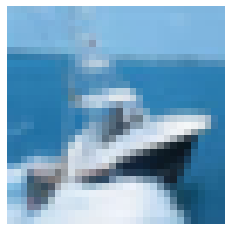

In [14]:
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()

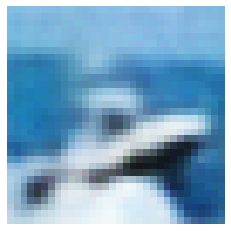

In [15]:
plt.imshow(X_recon.numpy().reshape(32, 32, 3))
plt.axis('off')
plt.show()

Check outliers on original CIFAR images

In [16]:
X = X_train[:500]
print(X.shape)

(500, 32, 32, 3)


In [17]:
od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)
print(list(od_preds['data'].keys()))

['instance_score', 'feature_score', 'is_outlier']


Plot instance level outlier scores

In [19]:
import numpy as np

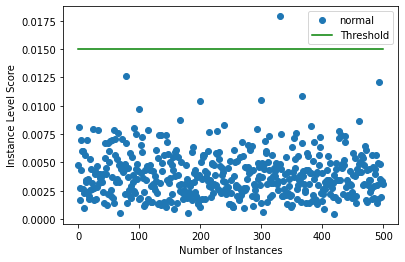

In [20]:
target = np.zeros(X.shape[0],).astype(int)  # all normal CIFAR10 training instances
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

Visualize predictions

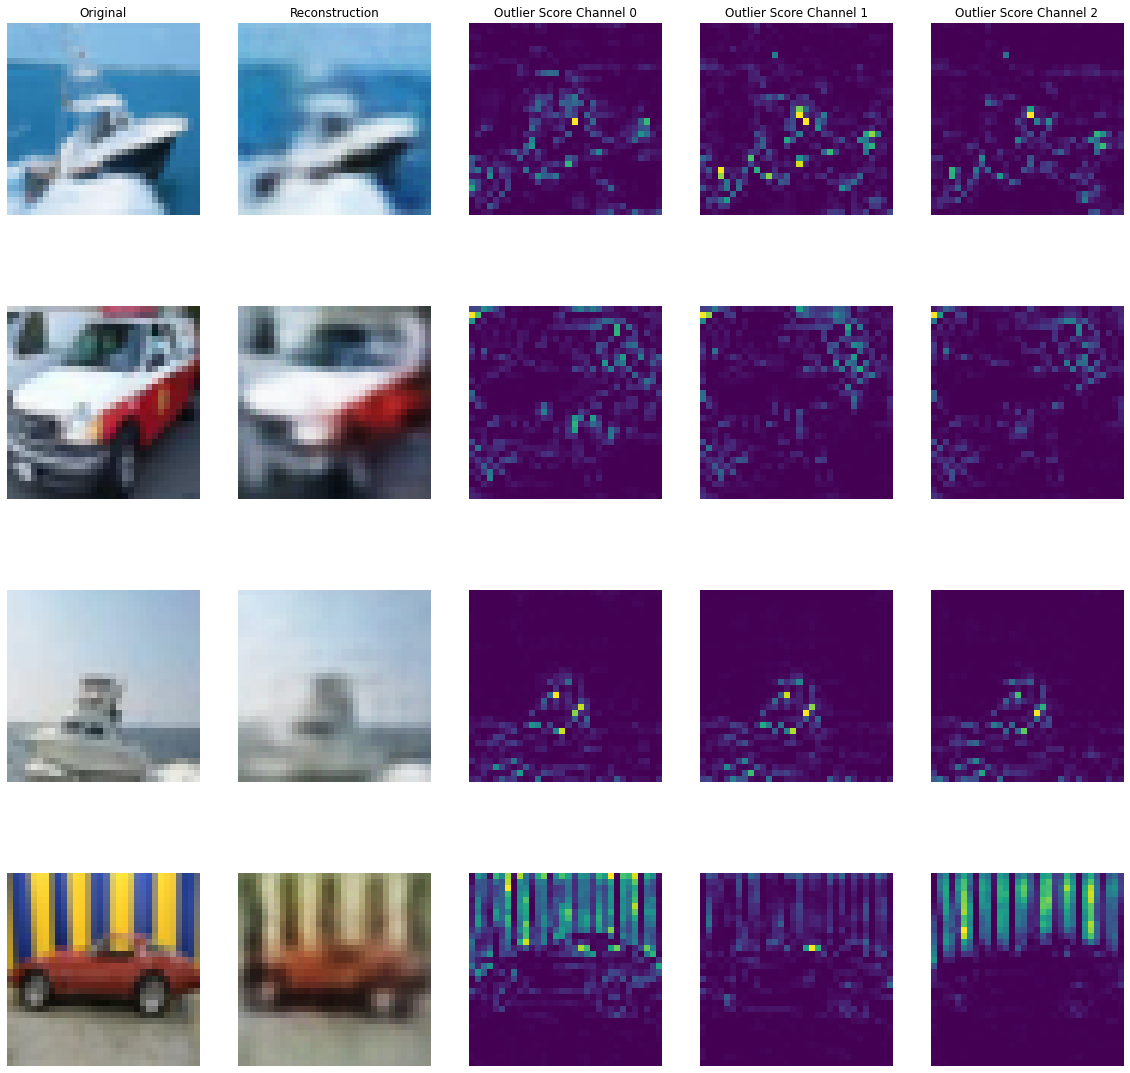

In [21]:
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
                           instance_ids=[8, 60, 100, 330],  # pass a list with indices of instances to display
                           max_instances=5,  # max nb of instances to display
                           outliers_only=False)  # only show outlier predictions

Predict outliers on perturbed CIFAR images
We perturb CIFAR images by adding random noise to patches (masks) of the image. For each mask size in n_mask_sizes, sample n_masks and apply those to each of the n_imgs images. Then we predict outliers on the masked instances:

In [22]:
# nb of predictions per image: n_masks * n_mask_sizes
n_mask_sizes = 10
n_masks = 20
n_imgs = 50

Define masks and get images:

In [23]:
mask_sizes = [(2*n,2*n) for n in range(1,n_mask_sizes+1)]
print(mask_sizes)
img_ids = np.arange(n_imgs)
X_orig = X[img_ids].reshape(img_ids.shape[0], 32, 32, 3)
print(X_orig.shape)

[(2, 2), (4, 4), (6, 6), (8, 8), (10, 10), (12, 12), (14, 14), (16, 16), (18, 18), (20, 20)]
(50, 32, 32, 3)


Calculate instance level outlier scores:

In [25]:
from tqdm import tqdm

In [26]:
all_img_scores = []
for i in tqdm(range(X_orig.shape[0])):
    img_scores = np.zeros((len(mask_sizes),))
    for j, mask_size in enumerate(mask_sizes):
        # create masked instances
        X_mask, mask = apply_mask(X_orig[i].reshape(1, 32, 32, 3),
                                  mask_size=mask_size,
                                  n_masks=n_masks,
                                  channels=[0,1,2],
                                  mask_type='normal',
                                  noise_distr=(0,1),
                                  clip_rng=(0,1))
        # predict outliers
        od_preds_mask = od.predict(X_mask)
        score = od_preds_mask['data']['instance_score']
        # store average score over `n_masks` for a given mask size
        img_scores[j] = np.mean(score)
    all_img_scores.append(img_scores)

100%|██████████| 50/50 [02:16<00:00,  2.74s/it]


Visualize outlier scores vs. mask sizes

In [27]:
x_plt = [mask[0] for mask in mask_sizes]

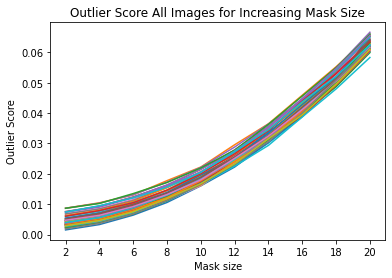

In [28]:
for ais in all_img_scores:
    plt.plot(x_plt, ais)
    plt.xticks(x_plt)
plt.title('Outlier Score All Images for Increasing Mask Size')
plt.xlabel('Mask size')
plt.ylabel('Outlier Score')
plt.show()

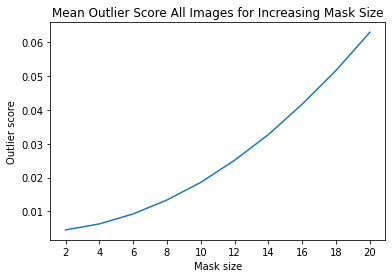

In [29]:
ais_np = np.zeros((len(all_img_scores), all_img_scores[0].shape[0]))
for i, ais in enumerate(all_img_scores):
    ais_np[i, :] = ais
ais_mean = np.mean(ais_np, axis=0)
plt.title('Mean Outlier Score All Images for Increasing Mask Size')
plt.xlabel('Mask size')
plt.ylabel('Outlier score')
plt.plot(x_plt, ais_mean)
plt.xticks(x_plt)
plt.show()

Investigate instance level outlier

In [30]:
i = 8  # index of instance to look at

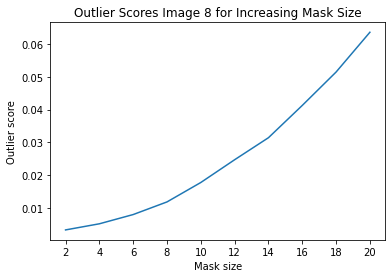

In [31]:
plt.plot(x_plt, all_img_scores[i])
plt.xticks(x_plt)
plt.title('Outlier Scores Image {} for Increasing Mask Size'.format(i))
plt.xlabel('Mask size')
plt.ylabel('Outlier score')
plt.show()

Reconstruction of masked images and outlier scores per channel:

In [32]:
all_X_mask = []
X_i = X_orig[i].reshape(1, 32, 32, 3)
all_X_mask.append(X_i)
# apply masks
for j, mask_size in enumerate(mask_sizes):
    # create masked instances
    X_mask, mask = apply_mask(X_i,
                              mask_size=mask_size,
                              n_masks=1,  # just 1 for visualization purposes
                              channels=[0,1,2],
                              mask_type='normal',
                              noise_distr=(0,1),
                              clip_rng=(0,1))
    all_X_mask.append(X_mask)
all_X_mask = np.concatenate(all_X_mask, axis=0)
all_X_recon = od.vae(all_X_mask).numpy()
od_preds = od.predict(all_X_mask)

Visualize:

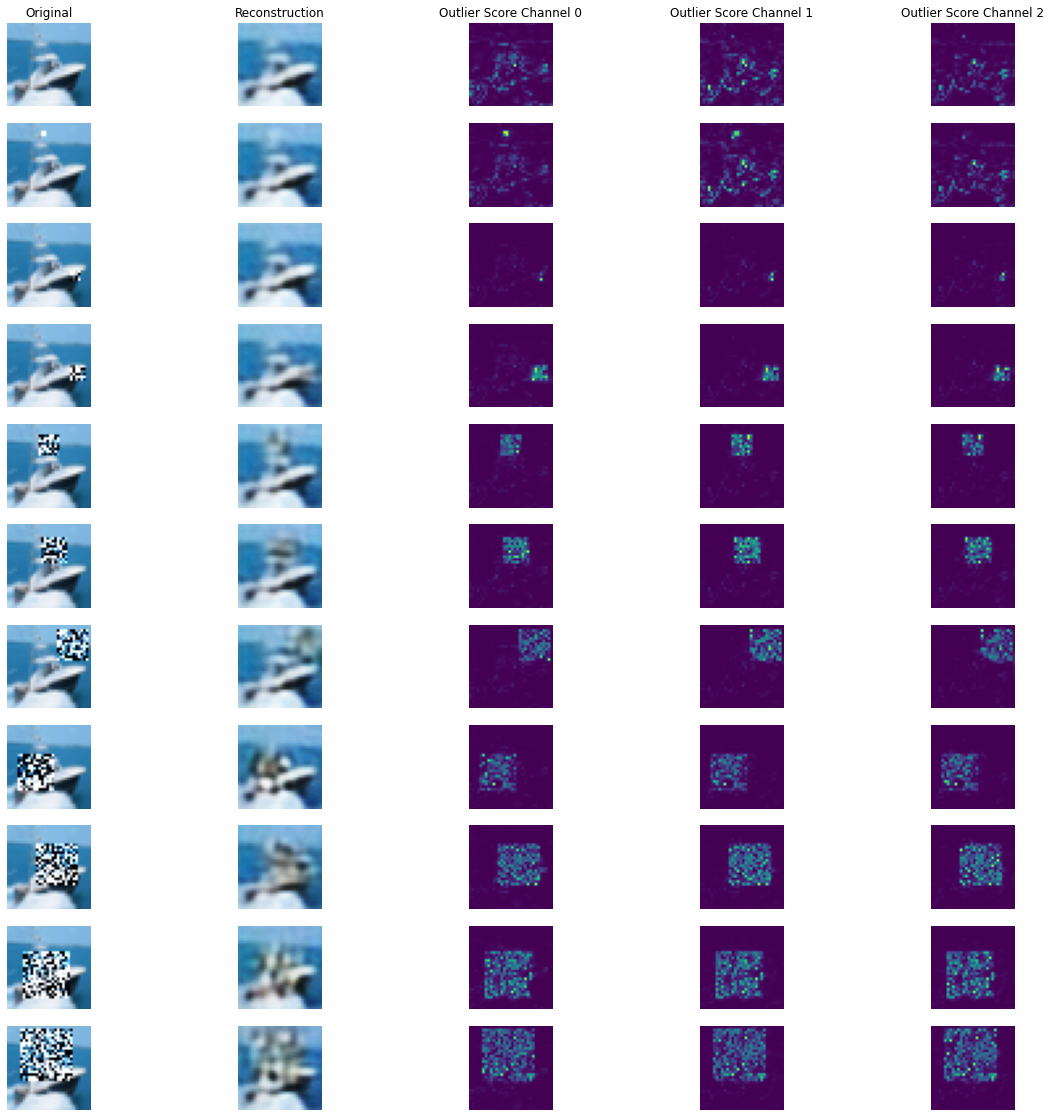

In [33]:
plot_feature_outlier_image(od_preds,
                           all_X_mask,
                           X_recon=all_X_recon,
                           max_instances=all_X_mask.shape[0],
                           n_channels=3)

Predict outliers on a subset of features
The sensitivity of the outlier detector can not only be controlled via the threshold, but also by selecting the percentage of the features used for the instance level outlier score computation. For instance, we might want to flag outliers if 40% of the features (pixels for images) have an average outlier score above the threshold. This is possible via the outlier_perc argument in the predict function. It specifies the percentage of the features that are used for outlier detection, sorted in descending outlier score order.

In [34]:
perc_list = [20, 40, 60, 80, 100]

all_perc_scores = []
for perc in perc_list:
    od_preds_perc = od.predict(all_X_mask, outlier_perc=perc)
    iscore = od_preds_perc['data']['instance_score']
    all_perc_scores.append(iscore)

Visualize outlier scores vs. mask sizes and percentage of features used:

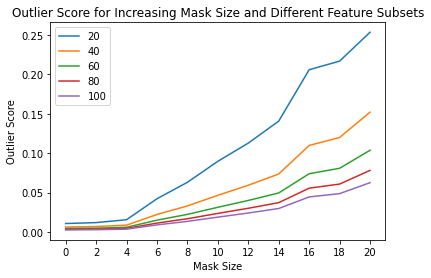

In [35]:
x_plt = [0] + x_plt
for aps in all_perc_scores:
    plt.plot(x_plt, aps)
    plt.xticks(x_plt)
plt.legend(perc_list)
plt.title('Outlier Score for Increasing Mask Size and Different Feature Subsets')
plt.xlabel('Mask Size')
plt.ylabel('Outlier Score')
plt.show()

Infer outlier threshold value
Finding good threshold values can be tricky since they are typically not easy to interpret. The infer_threshold method helps finding a sensible value. We need to pass a batch of instances X and specify what percentage of those we consider to be normal via threshold_perc.

In [36]:
print('Current threshold: {}'.format(od.threshold))
od.infer_threshold(X, threshold_perc=99)  # assume 1% of the training data are outliers
print('New threshold: {}'.format(od.threshold))

Current threshold: 0.015
New threshold: 0.010383214280009267
